# Portfolio Optimization

We want to use [SciPy optimizer](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html)  to find optimal weights for portofolio allocation given a number of constraints and bounds.

SciPy only support minimization. So, to maximize expected parameters, we need to negate __fun__ return value.

We need:

    1. A simple contraint would be that we can't have more than 100% allocation, bounds. We want to invest all, this is another constraint.
    2. Allocation bounds which tells the minimize function that each of our positions can only be between 0% and 100% of the allocation.
    3. Need to define the constraint which will be a fun(function) that ensures we equ(equal) a 100% allocated portfolio.
    4. Initial values - can be anything, in this particular example we use equal weights.

Once we've define this steps we can run the optimization by passing through the arguments defined and defining the method as SLSQP which is short for Sequential Least Squares Programming. So what the optimizer does is it searches for the vector of portfolio weights (W) that minimize func given our supplied expected returns.

Returned values are optimization result would give us optimized allocation for the portfolio


In [8]:
import pathlib
import sys
import os
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tabulate import tabulate

In [9]:
logger = logging.getLogger(__name__)
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO, stream=sys.stdout)

In [10]:
# Set ipython's max row display
pd.set_option('display.max_row', 1000)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 50)

#### Global variables

In [11]:
DATA_DIR = os.getenv('DATA_DIR', os.path.join(os.path.expanduser('~'), r'Data/quant/prices'))
HISTORICAL_PRICES_5_YRS = os.path.join(DATA_DIR, 'prices_5yrs.csv')
HISTORICAL_PRICES_10_YRS = os.path.join(DATA_DIR, 'prices_10yrs.csv')
tickers = ['AAPL','MSFT','AMZN','GOOG','FB','WMT','JPM','TSLA','NFLX','ADBE']

#### PCT dependencies

In [12]:
from pct.data.data_reader import SimpleIndexedCSVDataset
from pct.core.parameters import OptimizerParameters
from pct.core.optimizer import SimplePortfolioReturnOptimizer

## EDA

#### Loading prices

In [13]:
ds = SimpleIndexedCSVDataset(fpath=HISTORICAL_PRICES_5_YRS)
df_prices = ds.read()

In [14]:
print(tabulate(df_prices.head(5), headers="keys"))

date                 ticker        open      high       low     close     volume
-------------------  --------  --------  --------  --------  --------  ---------
2016-04-11 00:00:00  AAPL       25.3385   25.7198   25.3059   25.3501  117630000
2016-04-11 00:00:00  MSFT       49.9658   50.571    49.7916   49.8007   21414200
2016-04-11 00:00:00  GOOG      743.02    745       736.05    736.1       1220100
2016-04-11 00:00:00  FB        110.7     110.91    108.77    108.99     39762300
2016-04-11 00:00:00  WMT        60.8647   61.1869   60.3009   60.3188    7865400


In [15]:
all_tickers = df_prices.ticker.unique().tolist()
all_tickers

['AAPL', 'MSFT', 'GOOG', 'FB', 'WMT', 'JPM', 'TSLA', 'NFLX', 'ADBE', 'AMZN']

#### Pivoting prices

In [16]:
df_prices.reset_index(inplace=True)
df_prices = df_prices.pivot(index='date', columns='ticker', values='close')

In [17]:
print(tabulate(df_prices.head(5), headers="keys"))

date                    AAPL    ADBE    AMZN      FB    GOOG      JPM     MSFT    NFLX    TSLA      WMT
-------------------  -------  ------  ------  ------  ------  -------  -------  ------  ------  -------
2016-04-11 00:00:00  25.3501   92.95  595.93  108.99  736.1   50.6131  49.8007  102.68  49.984  60.3188
2016-04-12 00:00:00  25.6803   93.42  603.17  110.61  743.09  51.5523  50.1125  106.98  49.564  61.5717
2016-04-13 00:00:00  26.0523   94.53  614.82  110.51  751.72  53.7351  50.7544  109.65  50.906  61.8849
2016-04-14 00:00:00  26.0663   94.44  620.75  110.84  753.2   54.4308  50.7636  110.42  50.372  61.5717
2016-04-15 00:00:00  25.5431   95.16  625.89  109.64  759     53.8047  51.0295  111.51  50.902  61.8044


<AxesSubplot:xlabel='date'>

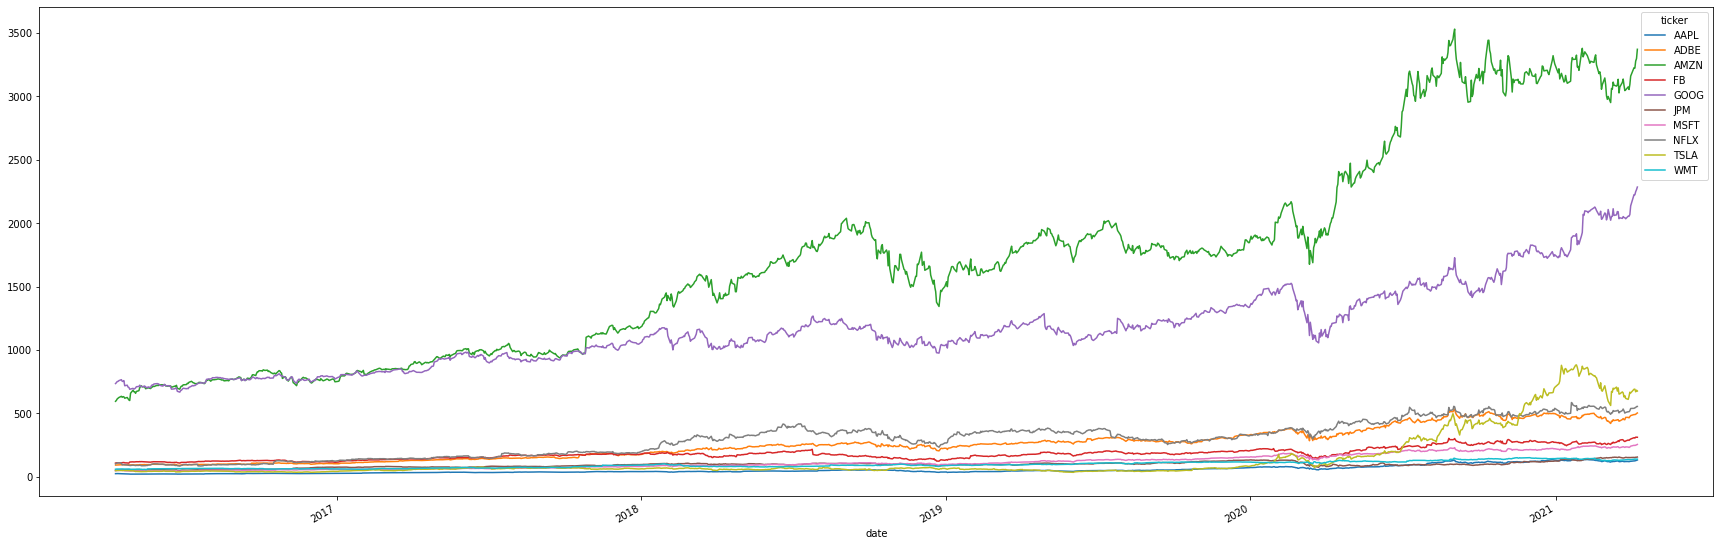

In [18]:
df_prices.plot(figsize=(30, 10))

#### Normalizing result to start with the same prices


In [19]:
df_normalized_prices = (df_prices / df_prices.iloc[0])

<AxesSubplot:xlabel='date'>

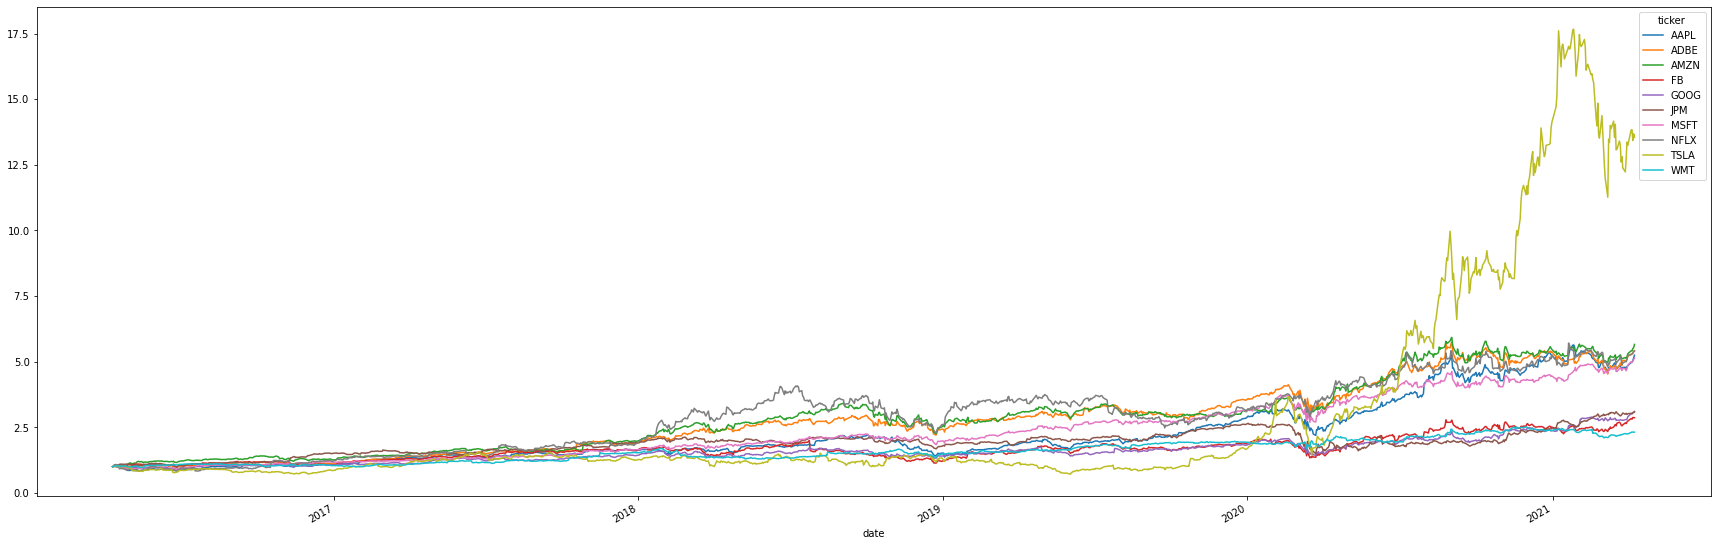

In [20]:
df_normalized_prices.plot(figsize=(30, 10))

#### Calculate log return 

In [21]:
df_return = np.log(1 + df_prices.pct_change())

In [22]:
print(tabulate(df_return[1:5], headers="keys"))

date                         AAPL          ADBE        AMZN            FB        GOOG         JPM         MSFT        NFLX         TSLA          WMT
-------------------  ------------  ------------  ----------  ------------  ----------  ----------  -----------  ----------  -----------  -----------
2016-04-12 00:00:00   0.0129411     0.00504375   0.0120759    0.0147544    0.00945126   0.0183868  0.00624109   0.0410246   -0.00843823   0.0205591
2016-04-13 00:00:00   0.0143834     0.0118118    0.0191305   -0.000904473  0.0115467    0.0414696  0.0127271    0.0246516    0.026716     0.00507389
2016-04-14 00:00:00   0.000535404  -0.000952493  0.00959887   0.00298165   0.00196694   0.0128639  0.000180743  0.00699777  -0.0105453   -0.00507389
2016-04-15 00:00:00  -0.0202755     0.00759499   0.00824624  -0.0108854    0.00767096  -0.0115702  0.00522478   0.00982303   0.0104667    0.0037716


<AxesSubplot:xlabel='date'>

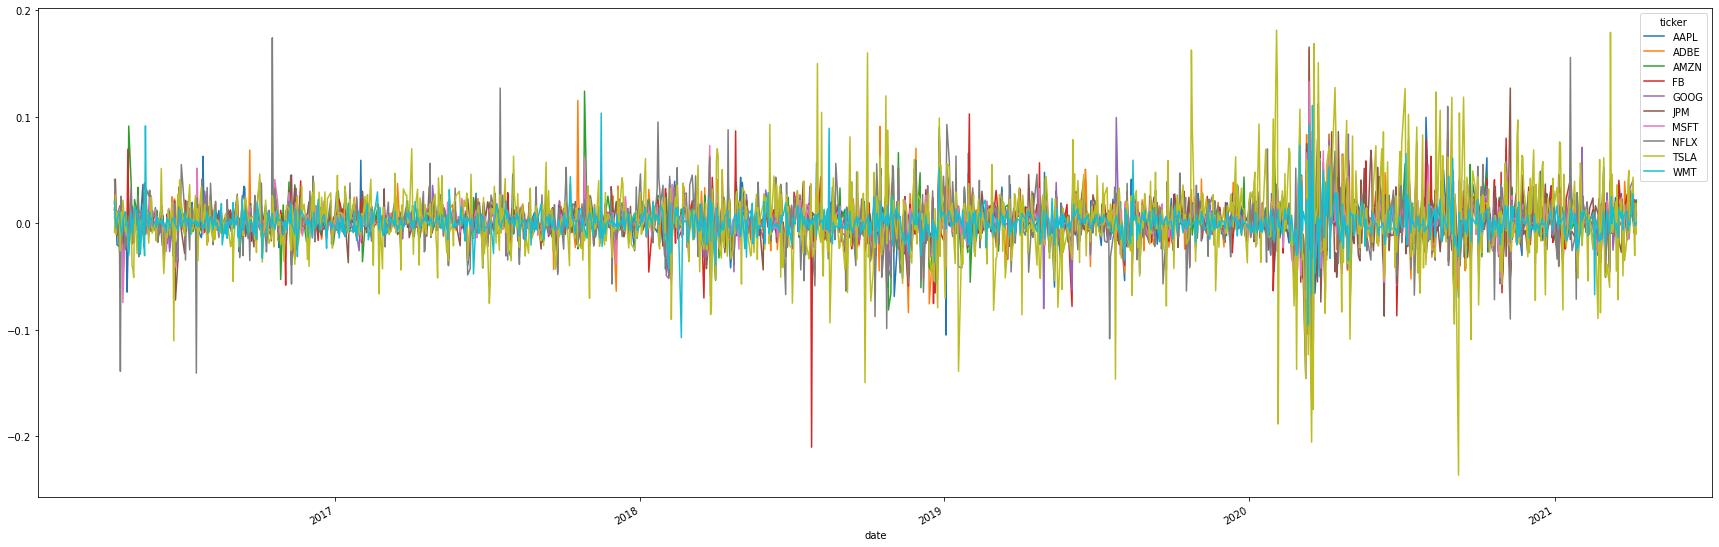

In [23]:
df_return.plot(figsize=(30, 10))

<AxesSubplot:xlabel='date'>

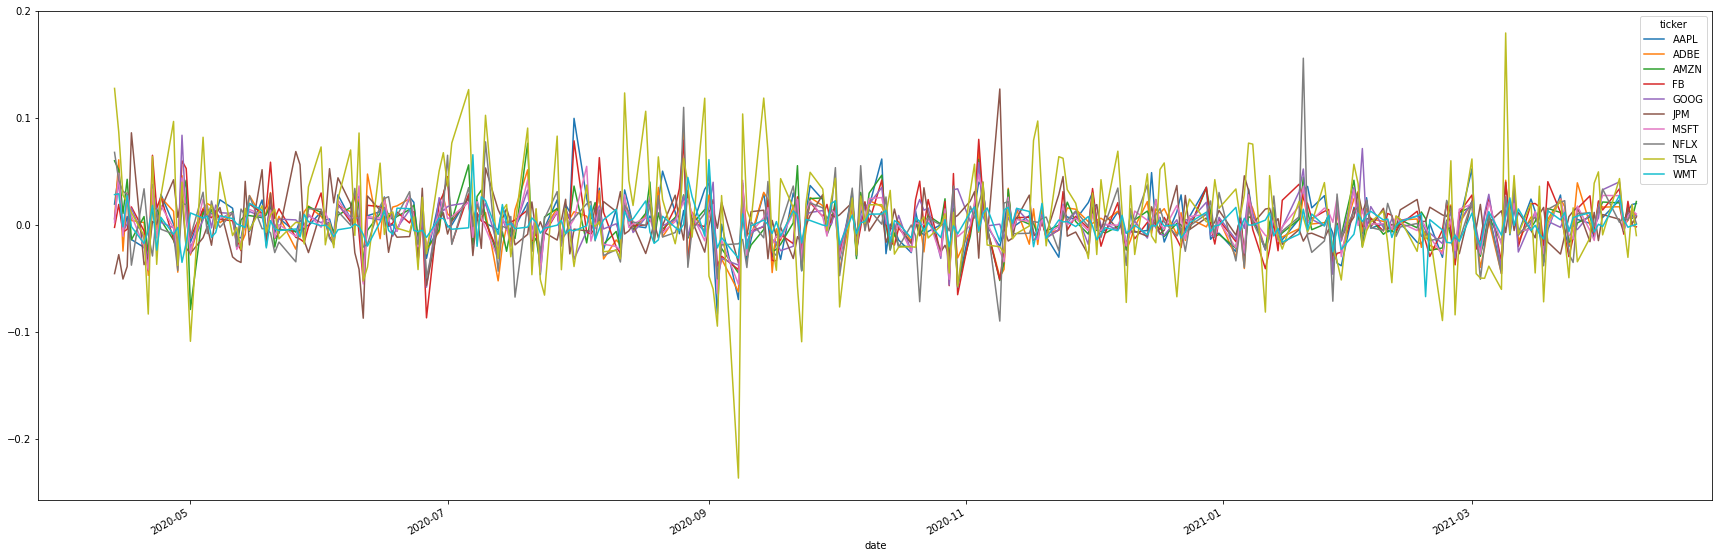

In [24]:
df_return[df_return.index > '2020-04-11'].plot(figsize=(30, 10))

#### Assets correlation
Return correlation between assets using 5 years of returns. The lower the better to find opportunities for diversification.

In [25]:
df_corr = df_return.corr()
df_corr.style.background_gradient(cmap='coolwarm').set_precision(4).set_properties(**{'font-size': '12pt'})

ticker,AAPL,ADBE,AMZN,FB,GOOG,JPM,MSFT,NFLX,TSLA,WMT
ticker,,,,,,,,,,
AAPL,1.0000,0.6460,0.6176,0.5961,0.6549,0.4418,0.7154,0.4645,0.4136,0.3518
ADBE,0.6460,1.0000,0.6770,0.6162,0.7020,0.3898,0.8062,0.5679,0.4197,0.3440
AMZN,0.6176,0.6770,1.0000,0.6213,0.6702,0.2697,0.7076,0.5975,0.3797,0.2916
FB,0.5961,0.6162,0.6213,1.0000,0.6838,0.3548,0.6362,0.4691,0.3350,0.2411
GOOG,0.6549,0.7020,0.6702,0.6838,1.0000,0.4830,0.7812,0.5186,0.3711,0.3168
JPM,0.4418,0.3898,0.2697,0.3548,0.4830,1.0000,0.5020,0.2133,0.2544,0.2588
MSFT,0.7154,0.8062,0.7076,0.6362,0.7812,0.5020,1.0000,0.5390,0.4226,0.4007
NFLX,0.4645,0.5679,0.5975,0.4691,0.5186,0.2133,0.5390,1.0000,0.3352,0.2556
TSLA,0.4136,0.4197,0.3797,0.3350,0.3711,0.2544,0.4226,0.3352,1.0000,0.1630


## Portfolio Return Optimization
This is a very trivial example of trying to use normalized close prices to find optimal weights

#### Loading historical prices to simulate portfolio

In [26]:

pricing_service = SimpleIndexedCSVDataset(fpath=HISTORICAL_PRICES_5_YRS)
df_prices = pricing_service.read()

#### Building up a portfolio with passed list of tickers

In [27]:

tickers = ['AAPL','MSFT','AMZN']
df_portfolio = df_prices[df_prices['ticker'].isin(tickers)]

#### Defining optimization parameters

- List of tickers
- Func(function) to optimize
- Constraints
- Bounds

In [28]:

constraints = {'sum_of_weights' : 'eq'}
        
request = {}
request[OptimizerParameters.TAG_KEY] = 'scipy_optimizer_v1'
request[OptimizerParameters.TICKERS_KEY] = tickers
request[OptimizerParameters.FUNCTION_KEY] = OptimizerParameters.PORTFOLIO_RETURN_FUNC
request[OptimizerParameters.CONSTRAINTS_KEY] = constraints

parameters = OptimizerParameters(**request)

2021-04-12 09:37:54,703 | INFO : Transforming optimization parameters


#### Simple portfolio optimization for a given list of constraints

In [29]:
optimizer = SimplePortfolioReturnOptimizer(parameters)

In [30]:
result = optimizer.optimize(df_portfolio=df_portfolio)

2021-04-12 09:37:56,388 | INFO : Starting 
2021-04-12 09:37:56,389 | INFO : Preparing portfolio
2021-04-12 09:37:56,397 | INFO : Number of records to process 1259


In [31]:
print(f"Sucsess: {result.success}")
print(f"Status: {result.status}")
print(f"Message: {result.message}")
print("-----------------------------")
for ticker, weight in result.weights.items():
    print(f"Ticker: {ticker} \t Optimized weight: {weight}")

Sucsess: True
Status: 0
Message: Optimization terminated successfully
-----------------------------
Ticker: AAPL 	 Optimized weight: 0
Ticker: MSFT 	 Optimized weight: 1
Ticker: AMZN 	 Optimized weight: 0


<AxesSubplot:>

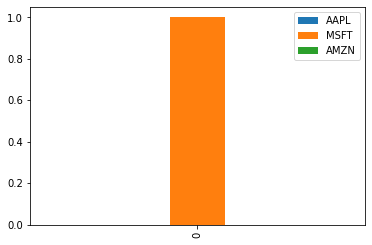

In [32]:
result_weights = { k:[v] for k,v in result.weights.items()}
df_weights = pd.DataFrame.from_dict(result_weights)
df_weights.plot(kind='bar')

## Sharpe Ratio Portfolio Optimization

#### Function to optimize

Since we are using an optimizer function that minimizes things, we need to add a negative sign on our return to risk ratio — that way when we minimize it, we are actually maximizing it.


Mathematically, we define the Sharpe Ratio as the following:

\begin{equation*}
\text{Sharpe Ratio} = \frac{(R_p - R_f)}{\sigma_p}
\end{equation*}

Where:

$
\begin{align}
\ R_p & = \text{Return of Portfolio} \\
\ R_f & = \text{Risk-Free Rate} \\
\ \sigma_p & = \text{Standard Deviation of Portfolio's Excess Return} \\
\end{align}
$


To calculate the expected returns, we use the following formula:

\begin{equation*}
\ R_p = (w_{1}r_{1}) + (w_{2}r_{2}) + \cdots + (w_{n}r_{n})
\end{equation*}

Where:

$
\begin{align}
\ r_{i} & = \text{Return of Security i} \\
\ w_{i} & = \text{Weight of Security i} \\
\end{align}
$

To calculate the standard deviation of the protfolio, we use the following formula:

\begin{equation*}
\ \sigma_p = \sqrt{(w_{i}^2 \sigma_i^2) + (w_{j}^2 \sigma_j^2) + (2w_{j}w_{i} p_{i,j} \sigma_i \sigma_j)}
\end{equation*}

Where:

$
\begin{align}
\ \sigma_{i} & = \text{Standard Deviation of Returns for Security i} \\
\ w_{i} & = \text{Weight of Security i} \\
\ p_{i,j} & = \text{Correlation Coefficent between the returns of asset i and asset j} \\
\end{align}
$



#### Optimization

1. Optimize risk by optimizing Sharp Ration
2. Optimize weights
3. Optimize volatility ratio



## References

[Portfolio Optimization With SciPy](https://towardsdatascience.com/portfolio-optimization-with-scipy-aa9c02e6b937)


https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html

[Understanding Portfolio Optimization](https://towardsdatascience.com/understanding-portfolio-optimization-795668cef596)

[Understanding Correlation And Diversification](https://towardsdatascience.com/understanding-correlation-and-diversification-661c19a26555)
